# Computational efficiency

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from matplotlib.ticker import ScalarFormatter

In [3]:
plt.rcParams['svg.fonttype'] = 'none'

In [4]:
methods = ['tmvec1', 'tmvec2', 'tmvec2_student', 'foldseek']
names = ['TM-Vec', 'TM-Vec 2', 'TM-Vec 2s', 'Foldseek']

Encoding

In [5]:
df = pd.read_table('encoding.tsv')
df.head()

,encoding_size,mean_seconds,method
0,10,0.355349,tmvec1
1,100,3.667599,tmvec1
2,1000,36.817476,tmvec1
3,5000,183.446004,tmvec1
4,10000,367.465977,tmvec1


In [6]:
sizes = sorted(df['encoding_size'].unique())
sizes

[10, 100, 1000, 5000, 10000, 50000]

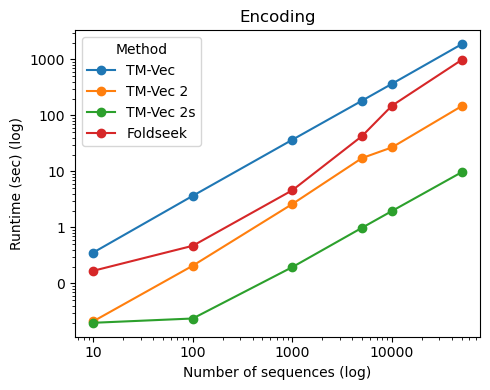

In [7]:
plt.figure(figsize=(5, 4))
for method, name in zip(methods, names):
    df_ = df.query(f'method == "{method}"')
    plt.plot('encoding_size', 'mean_seconds', data=df_, marker='o', label=name)
plt.legend(title='Method')
plt.xscale('log')
plt.yscale('log')
plt.gca().xaxis.set_major_formatter(ScalarFormatter())
plt.gca().yaxis.set_major_formatter(ScalarFormatter())
plt.xlabel('Number of sequences (log)')
plt.ylabel('Runtime (sec) (log)')
plt.title('Encoding')
plt.tight_layout()
plt.savefig('plots/encoding.svg')

In [8]:
df['seqs_per_second'] = df['encoding_size'] / df['mean_seconds']

In [9]:
s_max = df.groupby('method')['seqs_per_second'].max().loc[methods]
s_max

method
tmvec1              28.141320
tmvec2             482.585968
tmvec2_student    5178.063995
foldseek           216.890503
Name: seqs_per_second, dtype: float64

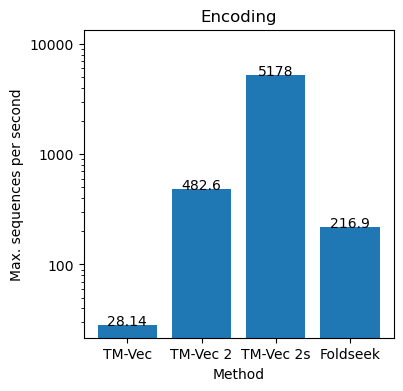

In [10]:
plt.figure(figsize=(4, 4))
plt.bar(x=methods, height=s_max.to_numpy())
for i, method in enumerate(methods):
    plt.text(i, s_max[method], '{:.4g}'.format(s_max[method]), ha='center')
plt.yscale('log')
plt.ylim(top=plt.ylim()[1] * 2)
plt.xlabel('Method')
plt.xticks(range(4), names)
plt.ylabel('Max. sequences per second')
plt.gca().yaxis.set_major_formatter(ScalarFormatter())
plt.title('Encoding')
plt.savefig('plots/maxseqs.svg')

Query

In [11]:
df = pd.read_table('query.tsv')
df.head()

,query_size,database_size,total_mean,method
0,10,1000,0.357020,tmvec1
1,100,1000,3.639644,tmvec1
2,1000,1000,36.834977,tmvec1
3,10,10000,0.362084,tmvec1
4,100,10000,3.711268,tmvec1


Benchmark results of BLAST and DIAMOND were adopted from Figure S7 of the TM-Vec 1 paper.

- https://www.nature.com/articles/s41587-023-01917-2

In [12]:
blast = pd.DataFrame([
    [10, 1000, 9],
    [100, 1000, 16],
    [1000, 1000, 65],
    [10, 10000, 10],
    [100, 10000, 25],
    [1000, 10000, 131],
    [10, 100000, 14],
    [100, 100000, 63],
    [1000, 100000, 175]
], columns=['query_size', 'database_size', 'total_mean']).assign(method='blast')

In [13]:
diamond = pd.DataFrame([
    [10, 1000, 0.521],
    [100, 1000, 0.512],
    [1000, 1000, 0.597],
    [10, 10000, 0.573],
    [100, 10000, 0.644],
    [1000, 10000, 0.775],
    [10, 100000, 1.234],
    [100, 100000, 1.395],
    [1000, 100000, 1.743]
], columns=['query_size', 'database_size', 'total_mean']).assign(method='diamond')

In [14]:
df = pd.concat([df, blast, diamond])

In [15]:
db_sizes = sorted(df['database_size'].unique())
db_sizes

[1000, 10000, 100000]

In [16]:
methods = ['tmvec1', 'tmvec2', 'tmvec2_student', 'foldseek', 'blast', 'diamond']
names = ['TM-Vec', 'TM-Vec 2', 'TM-Vec 2s', 'Foldseek', 'BLAST', 'DIAMOND']

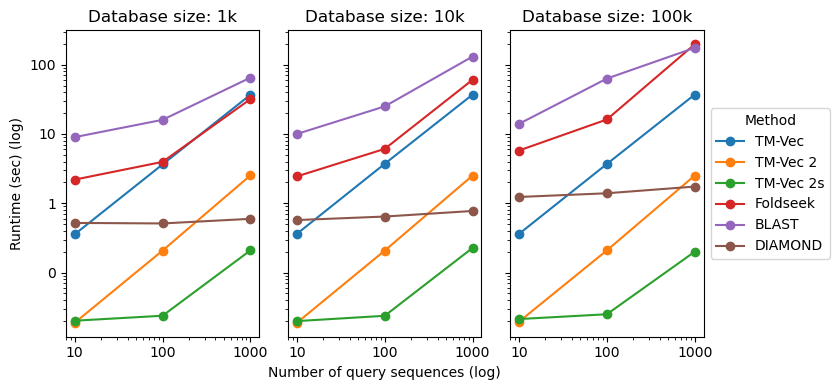

In [17]:
fig, axes = plt.subplots(1, 3, sharey=True, figsize=(8.5, 4))
for i, size in enumerate(db_sizes):
    ax = axes[i]
    for method, name in zip(methods, names):
        df_ = df.query(f'database_size == {size} & method == "{method}"')
        ax.plot('query_size', 'total_mean', data=df_, marker='o', label=name)
    ax.set_xscale('log')
    ax.xaxis.set_major_formatter(ScalarFormatter())
    if i == 0:
        ax.set_ylabel('Runtime (sec) (log)')
        ax.set_yscale('log')
        ax.yaxis.set_major_formatter(ScalarFormatter())
    if i == 1:
        ax.set_xlabel('Number of query sequences (log)')
    ax.set_title(f'Database size: {int(size / 1000)}k')
    if i == 2:
        ax.legend(title='Method', loc='center left', bbox_to_anchor=(1.0, 0.5))
fig.tight_layout()
fig.savefig('plots/query.svg')